In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\povil\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
import fiftyone as fo

classes = ["Mushroom", "Strawberry", "Orange"]
num_classes = len(classes)

dataset = fo.zoo.load_zoo_dataset(
    "open-images-v6",
    split="train",
    label_types="segmentations",
    classes=classes,
    max_samples=250,
    dataset_dir="./data"
)

dataset.compute_metadata()

Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'open-images-v6-train-250'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [3]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class OpenImagesDataset(Dataset):
    def __init__(self, fiftyone_dataset, classes, transform=None):
        self.samples = fiftyone_dataset
        self.transform = transform
        self.img_paths = self.samples.values("filepath")
        self.classes = classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]

        detections = sample.ground_truth.detections
        mask = None
        label = None
        size = (sample.metadata["width"], sample.metadata["height"])
        for d in detections:
            if d.label in classes:
                label = d.label
                partial_mask = d.to_segmentation(frame_size=size).mask
                if mask is None:
                    mask = partial_mask
                else:
                    mask = np.maximum(mask, d.to_segmentation(frame_size=size).mask)
        
        label = self.labels_map_rev[label]
        image = Image.open(img_path).convert("RGB")
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, label, mask
    
    def __len__(self):
        return len(self.samples)

In [4]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights
from torch import nn

weights = DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
model = deeplabv3_mobilenet_v3_large(weights=weights)
filters_of_last_layer = model.classifier[4].in_channels
filters_of_last_layer_aux = model.aux_classifier[4].in_channels
model.classifier[4] = nn.Conv2d(filters_of_last_layer,num_classes,kernel_size=(1,1),stride=(1,1))
model.aux_classifier[4] = nn.Conv2d(filters_of_last_layer_aux,num_classes, kernel_size=(1,1),stride=(1,1))
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [81]:
from torchvision import transforms
from torch.utils.data import random_split, DataLoader


batch_size = 4
learning_rate = 0.001
num_epochs = 5

transform = transforms.Compose([
    transforms.Resize((520,520), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
])

full_dataset = OpenImagesDataset(dataset, classes=classes, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [82]:
def filter_outputs(outputs, labels):
    filtered_results = []

    for i, output in enumerate(outputs):
        filtered_results.append(output[labels[i].item(), :, :].unsqueeze(dim=0))
        
    return torch.stack(filtered_results, dim=0)

In [7]:
losses = []
v_losses = []

model.train(True)
for epoch in range(num_epochs):
    for _, (images, labels, masks) in enumerate(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)["out"]
        outputs = filter_outputs(outputs, labels)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()
        
    losses.append(loss)

    with torch.no_grad():
        for _, (v_images, v_labels, v_masks) in enumerate(val_dataloader):
            v_images = v_images.to(device)
            v_masks = v_masks.to(device)

            v_outputs = model(v_images)["out"]
            v_outputs = filter_outputs(v_outputs, v_labels)
            v_loss = criterion(v_outputs, v_masks)

        v_losses.append(v_loss)

    print('Epoch [{}/{}] - Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, num_epochs, loss, v_loss))

model.train(False)

Epoch [1/5] - Training Loss: 0.3152, Validation Loss: 0.1963
Epoch [2/5] - Training Loss: 0.0786, Validation Loss: 0.1546
Epoch [3/5] - Training Loss: 0.1277, Validation Loss: 0.1038
Epoch [4/5] - Training Loss: 0.1479, Validation Loss: 0.1851
Epoch [5/5] - Training Loss: 0.0908, Validation Loss: 0.1764


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [80]:
torch.save(model.state_dict(), "checkpoint.pth")

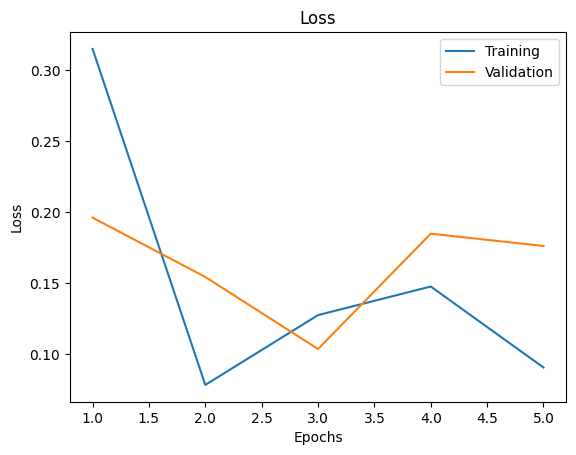

In [67]:
import matplotlib.pyplot as plt

copy_losses = [x.cpu().item() for x in losses]
copy_v_losses = [x.cpu().item() for x in v_losses]

epoch_array = list(range(1,num_epochs+1))

plt.plot(epoch_array, copy_losses, label = "Training")
plt.plot(epoch_array, copy_v_losses, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')

plt.title("Loss")

plt.show()

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import draw_segmentation_masks

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def apply_threshold(model_output, threshold=0.5):
    return torch.where(model_output > threshold, 1.0, 0.0)

def show_imgs_with_masks(images, model_output, threshold=0.5):
    outputs_sig = torch.sigmoid(model_output)
    masks = apply_threshold(outputs_sig, threshold=threshold)
    image_with_mask = [
        draw_segmentation_masks(F.convert_image_dtype(img, dtype=torch.uint8).cpu(), masks=mask.to(torch.bool).cpu(), alpha=0.4, colors="#FF00FF")
        for img, mask in zip(images, masks)
    ]

    show(image_with_mask)

In [79]:
def dispay_img_with_masks(images, masks, outputs):
    toImage = transforms.ToPILImage()
    predicted_masks = torch.tensor(outputs)
    predicted_masks = apply_threshold(predicted_masks)

    fig, axs = plt.subplots(ncols=3, nrows=len(images), squeeze=False)

    axs[0, 0].set_title("Image")
    axs[0, 1].set_title("Predicted Mask")
    axs[0, 2].set_title("Ground-Truth Mask")

    for i, image in enumerate(images):

        image = toImage(image)
        predicted_mask = toImage(predicted_masks[i])
        mask = toImage(masks[i])

        axs[i, 0].imshow(np.asarray(image))
        axs[i, 1].imshow(np.asarray(predicted_mask), cmap='gray')
        axs[i, 2].imshow(np.asarray(mask), cmap='gray')

        axs[i, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[i, 1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[i, 2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

C:\Users\povil\AppData\Local\Temp\ipykernel_9968\391859666.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_masks = torch.tensor(outputs)


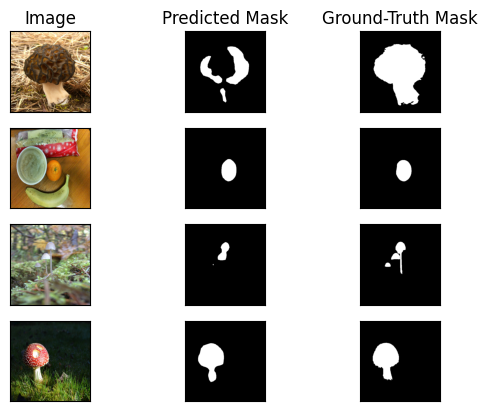

In [83]:
model.load_state_dict(torch.load('checkpoint.pth'))

predictions = []
targets = []
first = True

with torch.no_grad():
    for _, (v_images, v_labels, v_masks) in enumerate(val_dataloader):
        v_images = v_images.to(device)
        v_masks = v_masks.to(device)

        v_outputs = model(v_images)["out"]
        v_outputs = filter_outputs(v_outputs, v_labels)

        if first:
            dispay_img_with_masks(v_images, v_masks, v_outputs)
            first = False
        
        for i, prediction in enumerate(v_outputs):
            predictions.append(prediction.tolist())
            targets.append(v_masks[i].tolist())


In [84]:
import torchmetrics
from tabulate import tabulate

def calculateMetrics(predictions, targets):
    thresholds = (x * 0.1 for x in range(1, 10))
    metrics = []

    for t in thresholds:
        dice_metric = torchmetrics.Dice(threshold=t)
        dice = "{:.3f}".format(dice_metric(predictions, targets).item())

        f1_micro_metric = torchmetrics.F1Score(task="binary", num_classes=num_classes, threshold=t, average="micro")
        f1_micro = "{:.3f}".format(f1_micro_metric(predictions, targets).item())

        f1_macro_metric = torchmetrics.F1Score(task="binary", num_classes=num_classes, threshold=t, average="macro")
        f1_macro = "{:.3f}".format(f1_macro_metric(predictions, targets).item())

        metrics.append([t, dice, f1_micro, f1_macro])

    return metrics

predictions_tensor = torch.tensor(predictions)
targets_tensor = torch.tensor(targets, dtype=torch.int) 

data = calculateMetrics(predictions_tensor, targets_tensor)
col_names = ["Threshold", "Dice", "Micro-F1", "Macro-F1"]

print(tabulate(data, headers=col_names))

  Threshold    Dice    Micro-F1    Macro-F1
-----------  ------  ----------  ----------
        0.1   0.782       0.695       0.695
        0.2   0.776       0.762       0.762
        0.3   0.77        0.786       0.786
        0.4   0.762       0.794       0.794
        0.5   0.753       0.787       0.787
        0.6   0.744       0.762       0.762
        0.7   0.733       0.715       0.715
        0.8   0.721       0.625       0.625
        0.9   0.708       0.456       0.456


C:\Users\povil\AppData\Local\Temp\ipykernel_9968\391859666.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_masks = torch.tensor(outputs)


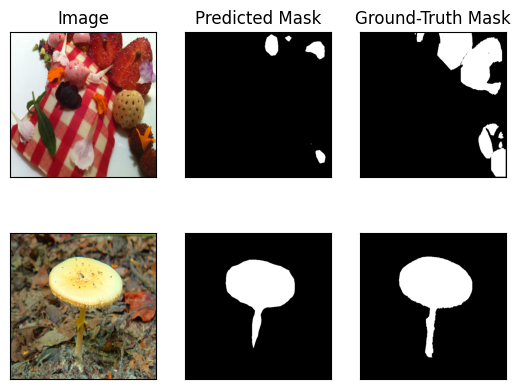

In [85]:
dispay_img_with_masks(v_images, v_masks, v_outputs)